In [1]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/nlile/hendrycks-MATH-benchmark/" + splits["train"])
df.shape

(12000, 6)

In [2]:
algebra_df = df[df['subject'] == 'Algebra']
algebra_df.shape

(2807, 6)

In [3]:
algebra_df=algebra_df.head(1200)

# Model the Dataset

In [4]:
from typing import Optional, List, Tuple, Union, Dict
from pydantic import BaseModel, Field

class Entity(BaseModel):
    problem: str
    solution: str
    answer: str
    subject: str
    level: int
    unique_id: str

class ReasoningPath(BaseModel):
    question: str
    reason: str
    answer: Optional[str]=None
    ground_truth: str
    temperature: float
    tokens: int
    score: float

entities = [Entity.model_validate(row) for row in algebra_df.to_dict(orient='records')]
print(len(entities))
print(entities[0])

1200
problem='How many vertical asymptotes does the graph of $y=\\frac{2}{x^2+x-6}$ have?' solution='The denominator of the rational function factors into $x^2+x-6=(x-2)(x+3)$. Since the numerator is always nonzero, there is a vertical asymptote whenever the denominator is $0$, which occurs for $x = 2$ and $x = -3$.  Therefore, the graph has $\\boxed{2}$ vertical asymptotes.' answer='2' subject='Algebra' level=3 unique_id='test/algebra/1.json'


# Generate SoTs

In [5]:
import re

from sketch_of_thought import SoT
from doraemon import Doraemon
from relaxed_fda import RelaxedFDA

logger=Doraemon.get_logger(name=__name__, logfile="math_dataset_builder.log")

paradigm = SoT.classify_question(entities[0].problem)
logger.info(paradigm)
assert "chunked_symbolism"==str(paradigm)

2025-06-23 09:53:47.935090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750672428.194003      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750672428.272399      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

2025-06-23 09:54:12,129 INFO chunked_symbolism


In [6]:
temperatures = [i * 0.25 for i in range(9)]  # [0.0, 0.25, 0.5, ... ,2.0]

tasks=[]
for et in entities:
    for tp in temperatures:
        tasks.append((et,paradigm,tp))

In [7]:
from tqdm import tqdm
import concurrent.futures

def process_entity(args)-> Optional[Dict[str, str]]:
    et,paradigm,temperature=args
    try:
        prompt=SoT.get_initialized_prompt(paradigm=paradigm, question=f"Question:{et.problem}")
        r_s, tokens=Doraemon.inference(logger=logger, messages=prompt, temperature=temperature)
        result=ReasoningPath(
            question=et.problem, 
            reason=str(r_s), 
            answer=RelaxedFDA.get_answer(r_s),
            ground_truth=str(et.answer),
            temperature=float(temperature), 
            tokens=int(tokens), 
            score=0.0)
        return result.model_dump()
    except Exception as e:
        logger.error(f"Error processing quetion {et.problem} at temperature {temperature} with exception {e}")
        return None

with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
    results=list(tqdm(executor.map(process_entity, tasks), total=len(tasks)))

100%|██████████| 10800/10800 [5:28:29<00:00,  1.82s/it]


In [8]:
results_filtered:List[Dict[str,str]] = [r for r in results if r is not None]

final_df=pd.DataFrame(results_filtered)

final_df.to_pickle('sots_df.pkl')

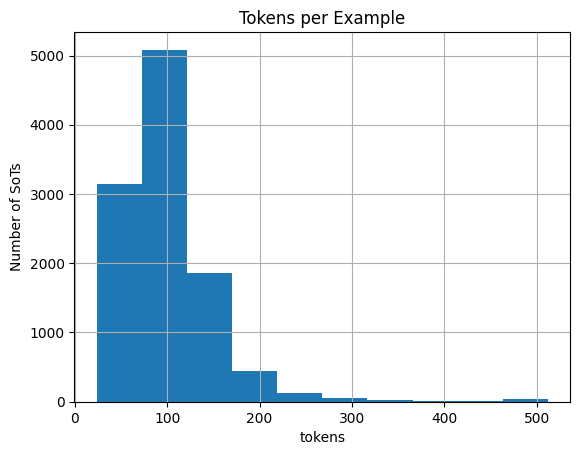

In [9]:
import matplotlib.pyplot as plt

# Tokens distribution
plt.figure()
final_df['tokens'].hist()
plt.title("Tokens per Example")
plt.xlabel("tokens")
plt.ylabel("Number of SoTs")
plt.show()